<a href="https://colab.research.google.com/github/itsMeJunaid/Health-Risk-Predictor-Full-Stack-ML-Application/blob/main/Pneumonia_Diagnosis_(96_AUC)_from_Chest_X_rays_MobileNetV2_%26_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

# 1. Pneumonia Detection using Chest X-Ray Images (Pneumonia)

 Classify chest X-ray images as either Pneumonia or Normal.

# 📂 2. Data Loading and Structure Check

In this section, we:
- Import libraries
- Mount Google Drive (if needed)
- Inspect the dataset folder structure
- Count and visualize image samples
- Check for corrupt/missing files
- Prepare for train/val/test splits if not already present


##  2.1 Import Required Libraries


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import shutil
import random

from sklearn.model_selection import train_test_split


##  2.2 Define Dataset Directory


In [ ]:
# Set this path to your actual dataset directory
dataset_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Check subdirectories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_dir, split)
    if os.path.exists(split_path):
        print(f"✅ Found: {split_path}")
    else:
        print(f"⚠️ Missing: {split_path}")


✅ Found: /kaggle/input/chest-xray-pneumonia/chest_xray/train
✅ Found: /kaggle/input/chest-xray-pneumonia/chest_xray/val
✅ Found: /kaggle/input/chest-xray-pneumonia/chest_xray/test


##  2.3 Count Images Per Class in Each Folder


In [ ]:
def count_images(path):
    class_counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            num_images = len(os.listdir(cls_path))
            class_counts[cls] = num_images
    return class_counts

for split in ['train', 'val', 'test']:
    print(f"\n📊 {split.upper()} Split:")
    print(count_images(os.path.join(dataset_dir, split)))



📊 TRAIN Split:
{'PNEUMONIA': 3875, 'NORMAL': 1341}

📊 VAL Split:
{'PNEUMONIA': 8, 'NORMAL': 8}

📊 TEST Split:
{'PNEUMONIA': 390, 'NORMAL': 234}


##  2.4 Visualize Sample Images from Each Class


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


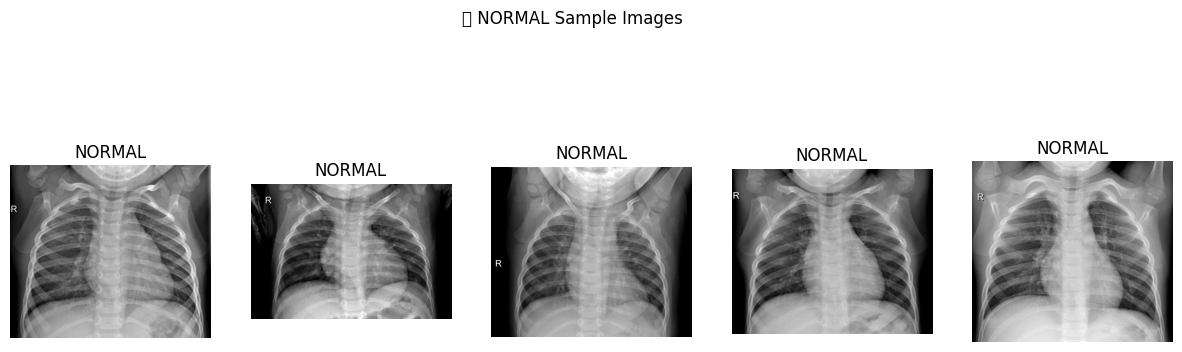

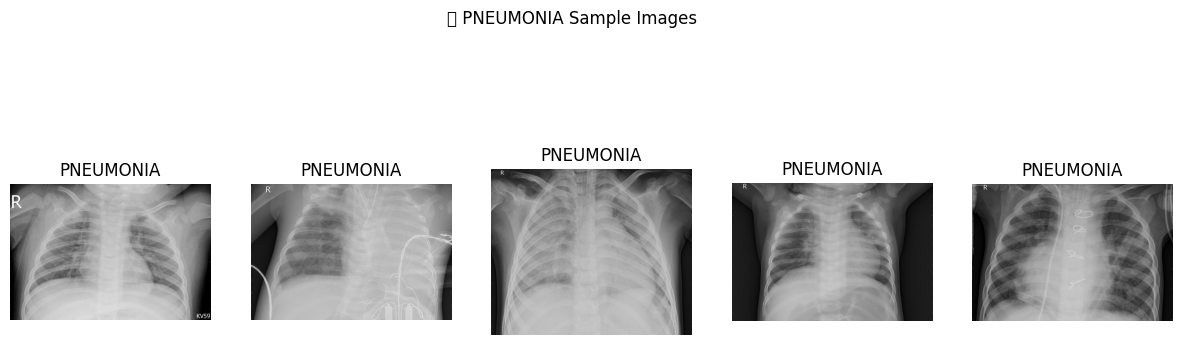

In [ ]:
def show_sample_images(base_path, class_name, num=5):
    class_path = os.path.join(base_path, class_name)
    sample_imgs = random.sample(os.listdir(class_path), num)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_imgs):
        img = Image.open(os.path.join(class_path, img_name))
        plt.subplot(1, num, i+1)
        plt.imshow(img.convert("L"), cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.suptitle(f"🔍 {class_name} Sample Images")
    plt.show()

# Example: Display 5 samples from training Normal and Pneumonia
show_sample_images(os.path.join(dataset_dir, 'train'), 'NORMAL', 5)
show_sample_images(os.path.join(dataset_dir, 'train'), 'PNEUMONIA', 5)


##  2.5 Check for Corrupted Images


In [ ]:
def check_corrupt_images(directory):
    corrupt_count = 0
    for root, _, files in os.walk(directory):
        for f in tqdm(files, desc=f"Checking {root}"):
            try:
                img_path = os.path.join(root, f)
                img = Image.open(img_path)
                img.verify()
            except:
                print(f"❌ Corrupt: {img_path}")
                corrupt_count += 1
    print(f"\n🧹 Total Corrupt Images: {corrupt_count}")

check_corrupt_images(dataset_dir)


Checking /kaggle/input/chest-xray-pneumonia/chest_xray: 0it [00:00, ?it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray: 100%|██████████| 1/1 [00:00<00:00, 33.15it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val: 100%|██████████| 1/1 [00:00<00:00, 748.18it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA: 100%|██████████| 9/9 [00:00<00:00, 1816.76it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL: 100%|██████████| 9/9 [00:00<00:00, 1378.75it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test: 100%|██████████| 1/1 [00:00<00:00, 1261.44it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA: 100%|██████████| 390/390 [00:00<00:00, 1839.21it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL: 100%|██████████| 234/234 [00:00<00:00, 1809.05it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train: 100%|██████████| 1/1 [00:00<00:00, 917.39it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA:  91%|█████████ | 3519/3876 [00:01<00:00, 2113.82it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA: 100%|██████████| 3876/3876 [00:01<00:00, 2112.69it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL: 100%|██████████| 1342/1342 [00:00<00:00, 1539.38it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX: 100%|██████████| 1/1 [00:00<00:00, 900.65it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray: 100%|██████████| 3/3 [00:00<00:00, 1544.11it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._.DS_Store
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._train
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._test


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val: 100%|██████████| 1/1 [00:00<00:00, 931.45it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/._.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA:   0%|          | 0/9 [00:00<?, ?it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1946_bacteria_4875.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1952_bacteria_4883.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1949_bacteria_4880.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._.DS_Store
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1950_bacteria_4881.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1947_bacteria_4876.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1951_bacteria_4882.jpeg


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA: 100%|██████████| 9/9 [00:00<00:00, 1757.80it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1946_bacteria_4874.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA/._person1954_bacteria_4886.jpeg


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL: 100%|██████████| 9/9 [00:00<00:00, 2039.48it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1442-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1436-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1430-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._.DS_Store
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1431-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1427-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1440-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/._NORMAL2-IM-1437-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL/

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test: 100%|██████████| 3/3 [00:00<00:00, 1840.68it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._NORMAL
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._.DS_Store


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA:  40%|████      | 157/390 [00:00<00:00, 1569.92it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person8_virus_28.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person122_bacteria_585.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person154_bacteria_728.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person1650_virus_2854.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person112_bacteria_538.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person157_bacteria_739.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person146_bacteria_704.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person133_bacteria_638.jpeg
❌ Corrupt: /kaggle/input/chest-

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA:  86%|████████▌ | 335/390 [00:00<00:00, 1689.19it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person102_bacteria_487.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person22_virus_55.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person35_virus_80.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person61_virus_118.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person86_bacteria_429.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person39_virus_85.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person21_virus_53.jpeg


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA: 100%|██████████| 390/390 [00:00<00:00, 1708.48it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person83_bacteria_411.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person66_virus_125.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person103_bacteria_490.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person152_bacteria_723.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person152_bacteria_720.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person94_bacteria_456.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person175_bacteria_835.jpeg
❌ Corrupt: /kaggle/input/chest

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL: 100%|██████████| 234/234 [00:00<00:00, 1907.37it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0036-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._NORMAL2-IM-0348-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0086-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._NORMAL2-IM-0259-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._NORMAL2-IM-0051-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._NORMAL2-IM-0329-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._NORMAL2-IM-0150-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._NORMAL2-IM-0330-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/tes

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train: 100%|██████████| 3/3 [00:00<00:00, 1005.91it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/._PNEUMONIA
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/._NORMAL
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/._.DS_Store



Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  11%|█         | 412/3876 [00:00<00:01, 2073.25it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person499_bacteria_2104.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person515_bacteria_2190.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person426_virus_873.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1171_bacteria_3118.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1119_virus_1844.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1507_bacteria_3942.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1816_bacteria_4674.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1320_bacteria_3339.jpeg
❌ Corrupt:

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  16%|█▌        | 620/3876 [00:00<00:01, 1950.69it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1599_virus_2775.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1020_bacteria_2951.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person734_virus_1355.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person567_bacteria_2352.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person721_virus_1340.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1657_bacteria_4398.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person387_bacteria_1769.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1496_bacteria_3909.jpeg
❌ Corrupt: /k

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  26%|██▌       | 1005/3876 [00:00<00:01, 1877.00it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1419_bacteria_3645.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1252_virus_2124.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person51_bacteria_247.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person813_virus_1449.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person629_bacteria_2509.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person554_virus_1094.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1375_virus_2366.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1544_bacteria_4037.jpeg
❌ Corrupt: /kaggle

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  36%|███▋      | 1413/3876 [00:00<00:01, 1928.67it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1438_virus_2452.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1349_bacteria_3438.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person36_bacteria_182.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person332_bacteria_1535.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person447_virus_921.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person259_bacteria_1220.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person740_virus_1362.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1493_bacteria_3895.jpeg
❌ Corrupt: /kaggl

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  47%|████▋     | 1814/3876 [00:00<00:01, 1964.13it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person527_bacteria_2225.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person549_bacteria_2306.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1086_bacteria_3026.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person557_bacteria_2327.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person749_bacteria_2652.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1342_virus_2315.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person68_bacteria_336.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person915_virus_1572.jpeg
❌ Corrupt: /ka

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  57%|█████▋    | 2208/3876 [00:01<00:00, 1901.56it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person933_bacteria_2858.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person376_bacteria_1715.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1295_bacteria_3258.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1707_bacteria_4520.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person322_bacteria_1494.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person649_bacteria_2541.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person61_bacteria_296.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1577_virus_2735.jpeg
❌ Corrupt:

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  67%|██████▋   | 2592/3876 [00:01<00:00, 1866.90it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person75_bacteria_369.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1639_bacteria_4347.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person414_virus_845.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1644_bacteria_4361.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person312_bacteria_1455.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1043_bacteria_2977.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person402_bacteria_1812.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person295_bacteria_1390.jpeg
❌ Corrupt: 

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  77%|███████▋  | 2985/3876 [00:01<00:00, 1905.85it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1910_bacteria_4814.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person548_bacteria_2299.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person872_bacteria_2795.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person305_bacteria_1437.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1142_bacteria_3086.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person515_bacteria_2185.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person432_virus_881.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1068_virus_1771.jpeg
❌ Corrupt: /

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA:  87%|████████▋ | 3371/3876 [00:01<00:00, 1909.51it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person281_virus_578.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person462_bacteria_1967.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person278_bacteria_1314.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person41_bacteria_208.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person438_bacteria_1891.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person413_bacteria_1833.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1074_bacteria_3014.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1080_virus_1791.jpeg
❌ Corrupt: /kag

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA: 100%|██████████| 3876/3876 [00:02<00:00, 1922.71it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1254_virus_2130.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person460_bacteria_1958.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person61_bacteria_290.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person81_virus_152.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person260_bacteria_1222.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1558_bacteria_4066.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person711_virus_1309.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person477_bacteria_2030.jpeg
❌ Corrupt: /kaggle/


Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL:  27%|██▋       | 357/1342 [00:00<00:00, 1785.56it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0473-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0416-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0696-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1419-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0343-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0753-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0851-0001-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1292-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL:  41%|████      | 545/1342 [00:00<00:00, 1827.12it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0166-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1202-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0566-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0467-0001-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1306-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0698-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0807-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0220-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL:  70%|██████▉   | 938/1342 [00:00<00:00, 1846.62it/s]

❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1266-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0845-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1152-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0555-0001-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1116-0001-0002.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1154-0001-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0645-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1379-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneum

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL: 100%|██████████| 1342/1342 [00:00<00:00, 1849.67it/s]


❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0933-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0672-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1155-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0243-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0530-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0145-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0443-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1310-0001.jpeg
❌ Corrupt: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/tra

Checking /kaggle/input/chest-xray-pneumonia/chest_xray/val: 0it [00:00, ?it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 2127.47it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL: 100%|██████████| 8/8 [00:00<00:00, 1013.79it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/test: 0it [00:00, ?it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA: 100%|██████████| 390/390 [00:00<00:00, 2322.26it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL: 100%|██████████| 234/234 [00:00<00:00, 2187.57it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/train: 0it [00:00, ?it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA: 100%|██████████| 3875/3875 [00:01<00:00, 2203.66it/s]
Checking /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL: 100%|██████████| 1341/1341 [00:00<00:00, 1727.24it/s]


🧹 Total Corrupt Images: 5879


# 📊 3. Exploratory Data Analysis (EDA)

EDA helps us understand the class distribution, sample quality, and visual patterns in images.
We will explore:
- 📦 Image count by class per split
- 📐 Image dimension distributions
- 📸 Visual examples (normal vs pneumonia)
- 🌈 Pixel intensity distributions
- 🧠 Image similarity (PCA & TSNE later)


## 🔹 3.1 Class Distribution per Split


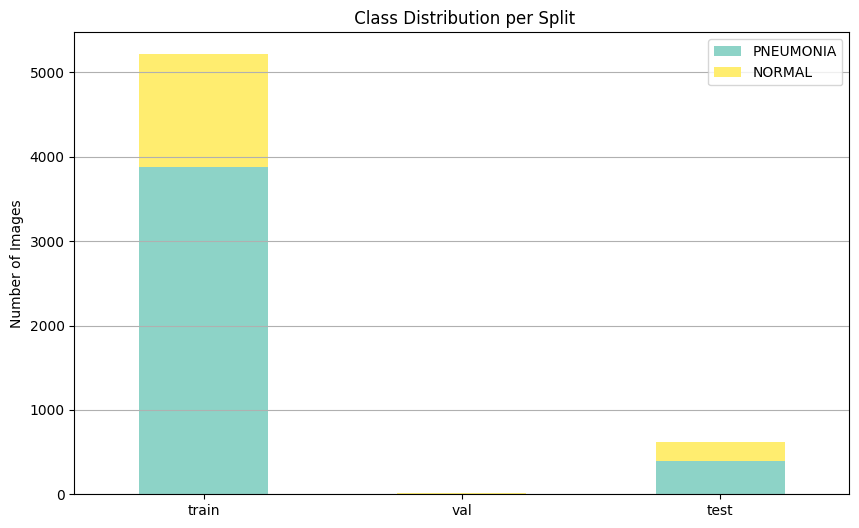

In [ ]:
splits = ['train', 'val', 'test']
class_dist = {}

for split in splits:
    path = os.path.join(dataset_dir, split)
    class_counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in os.listdir(path)}
    class_dist[split] = class_counts

df_dist = pd.DataFrame(class_dist)
df_dist.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap="Set3")
plt.title(" Class Distribution per Split")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


##  3.2 Image Size Distribution


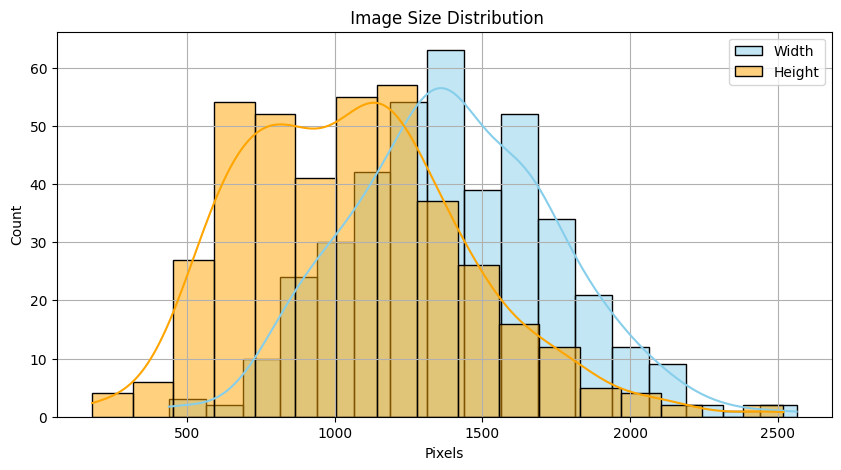

In [ ]:
image_shapes = []
base_path = os.path.join(dataset_dir, 'train')

for cls in os.listdir(base_path):
    class_path = os.path.join(base_path, cls)
    files = random.sample(os.listdir(class_path), 200)  # sample 200 for speed
    for f in files:
        img = Image.open(os.path.join(class_path, f))
        image_shapes.append(img.size)

widths, heights = zip(*image_shapes)
plt.figure(figsize=(10,5))
sns.histplot(widths, color="skyblue", label='Width', kde=True)
sns.histplot(heights, color="orange", label='Height', kde=True)
plt.title(" Image Size Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.grid(True)
plt.show()


##  3.3 Image Brightness/Intensity Distribution


100%|██████████| 500/500 [00:03<00:00, 164.66it/s]


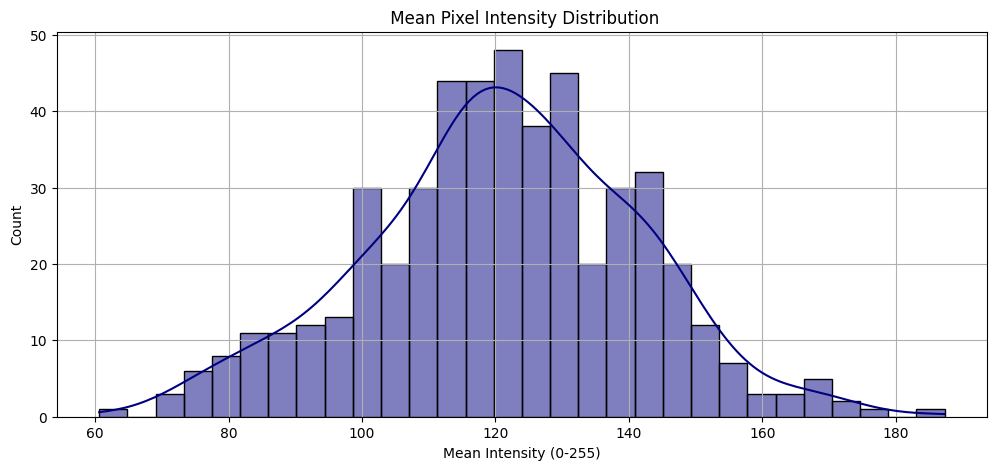

In [ ]:
def get_pixel_stats(image_paths):
    means = []
    stds = []

    for img_path in tqdm(image_paths[:500]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        means.append(np.mean(img))
        stds.append(np.std(img))
    return means, stds

train_path = os.path.join(dataset_dir, 'train')
all_image_paths = []

for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    all_image_paths.extend([os.path.join(cls_path, f) for f in os.listdir(cls_path)])

means, stds = get_pixel_stats(all_image_paths)

plt.figure(figsize=(12, 5))
sns.histplot(means, bins=30, color='navy', kde=True)
plt.title(" Mean Pixel Intensity Distribution")
plt.xlabel("Mean Intensity (0-255)")
plt.grid(True)
plt.show()


##  3.4 Visual Comparison: NORMAL vs PNEUMONIA


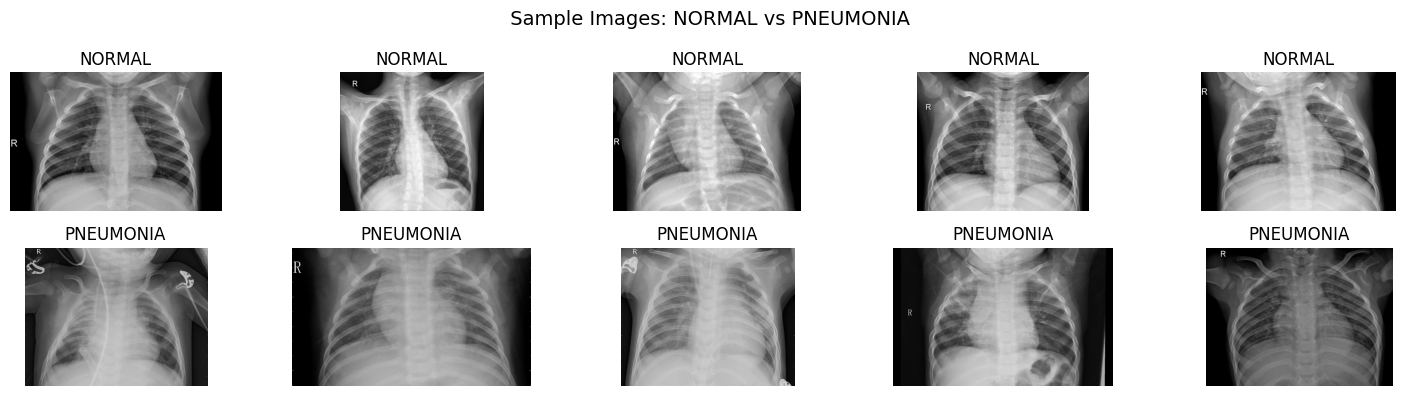

In [ ]:
def plot_class_samples(split='train', num=5):
    plt.figure(figsize=(15, 4))
    for i, cls in enumerate(['NORMAL', 'PNEUMONIA']):
        class_path = os.path.join(dataset_dir, split, cls)
        sample_files = random.sample(os.listdir(class_path), num)
        for j, file in enumerate(sample_files):
            img = Image.open(os.path.join(class_path, file))
            plt.subplot(2, num, i*num + j + 1)
            plt.imshow(img.convert('L'), cmap='gray')
            plt.title(f"{cls}")
            plt.axis('off')
    plt.suptitle(" Sample Images: NORMAL vs PNEUMONIA", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_class_samples('train', 5)


##  3.5 Optional: Average Image Per Class
Helps identify texture/pattern differences.


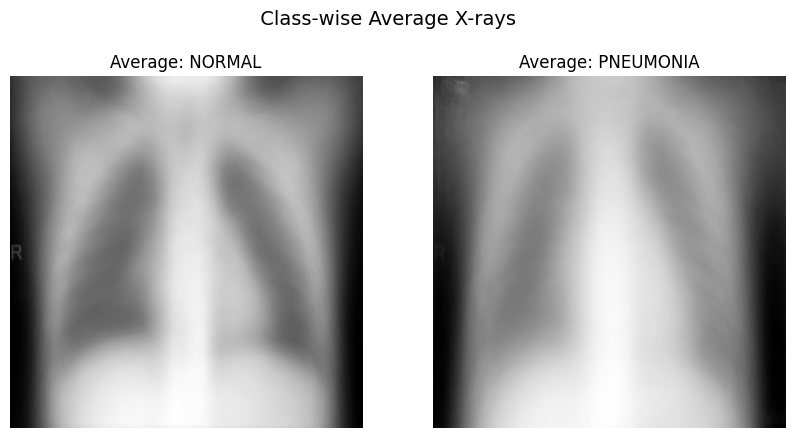

In [ ]:
def average_image(path):
    images = []
    for f in random.sample(os.listdir(path), 300):
        img = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        images.append(img)
    return np.mean(images, axis=0)

normal_avg = average_image(os.path.join(dataset_dir, 'train/NORMAL'))
pneumonia_avg = average_image(os.path.join(dataset_dir, 'train/PNEUMONIA'))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(normal_avg, cmap='gray')
plt.title("Average: NORMAL")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pneumonia_avg, cmap='gray')
plt.title("Average: PNEUMONIA")
plt.axis('off')
plt.suptitle(" Class-wise Average X-rays", fontsize=14)
plt.show()


# 🧼 4. Image Preprocessing & Augmentation

To improve model generalization and performance, we need a strong preprocessing pipeline.

### Key Preprocessing Steps:
- 🖼 Resize to standard dimensions (224x224)
- 🌈 Convert to 3 channels (RGB)
- 🧮 Normalize pixel values [0-1]
- 🧪 Augment training set:
  - Random Zoom, Shift, Rotate, Flip
  - Brightness & Contrast Tweaks


In [ ]:
! pip install albumentations

In [ ]:
# 📦 Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import transforms as T
from albumentations import geometric as G
from albumentations import blur as B
from albumentations import crops as C

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## 🔹 4.1 Define Albumentations Transform (for Training)


In [ ]:
albumentation_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=10, p=0.3),
    A.ZoomBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.4),
    A.OneOf([
        A.GaussianBlur(p=0.2),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.2)
    ], p=0.3),
    A.Normalize(),  # mean=0, std=1
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


##  4.2 Keras Generator with Albumentations (Custom Pipeline)


In [ ]:
import tensorflow as tf
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, transform, batch_size=32, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for path in batch_paths:
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            augmented = self.transform(image=image)
            images.append(augmented['image'])

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            zipped = list(zip(self.image_paths, self.labels))
            random.shuffle(zipped)
            self.image_paths, self.labels = zip(*zipped)

## 🔹 4.3 Create Data Loaders for Train, Val, and Test


In [ ]:
def get_image_paths_and_labels(folder):
    classes = sorted(os.listdir(folder))
    class_map = {cls: idx for idx, cls in enumerate(classes)}
    image_paths = []
    labels = []

    for cls in classes:
        class_path = os.path.join(folder, cls)
        for f in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, f))
            labels.append(class_map[cls])

    return image_paths, labels

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

train_paths, train_labels = get_image_paths_and_labels(train_dir)
val_paths, val_labels = get_image_paths_and_labels(val_dir)
test_paths, test_labels = get_image_paths_and_labels(test_dir)

# Train uses augmentation, validation/test use resize+normalize only
val_aug = A.Compose([A.Resize(224, 224), A.Normalize()])

train_loader = CustomDataGen(train_paths, train_labels, albumentation_train, batch_size=32)
val_loader = CustomDataGen(val_paths, val_labels, val_aug, batch_size=32, shuffle=False)
test_loader = CustomDataGen(test_paths, test_labels, val_aug, batch_size=32, shuffle=False)


## ✅ Summary of Step 4:

- Custom `Albumentations` augmentations are **stronger than traditional Keras** generators.
- Data is fed in real-time via a `Sequence` class.
- Highly modular: easy to plug into model training.


# 🧪 5. Train-Validation-Test Split (Advanced)

Proper splitting ensures:
- ✅ No data leakage
- ✅ Balanced class distribution
- ✅ Generalization across unseen patients


## 5.1 Strategy: Patient-wise Stratified Splitting
In medical datasets, multiple X-rays from the same patient can cause data leakage if they appear in both training and testing.

In [ ]:
import os
from collections import Counter

def count_images(path):
    count = {}
    for label in ['NORMAL', 'PNEUMONIA']:
        label_dir = os.path.join(path, label)
        count[label] = len(os.listdir(label_dir))
    return count

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("✅ Train:", train_counts)
print("✅ Val:", val_counts)
print("✅ Test:", test_counts)


✅ Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
✅ Val: {'NORMAL': 8, 'PNEUMONIA': 8}
✅ Test: {'NORMAL': 234, 'PNEUMONIA': 390}


## 5.2 If Manual Split is Needed from Raw Folder
Use Stratified Split + Patient Metadata (if available):

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📍 Define paths
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# 🔁 Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 🎯 Load from directory
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode="binary", shuffle=True)

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32,
    class_mode="binary", shuffle=False)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32,
    class_mode="binary", shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


##  5.3 Class Distribution Plot (Check for Imbalance)


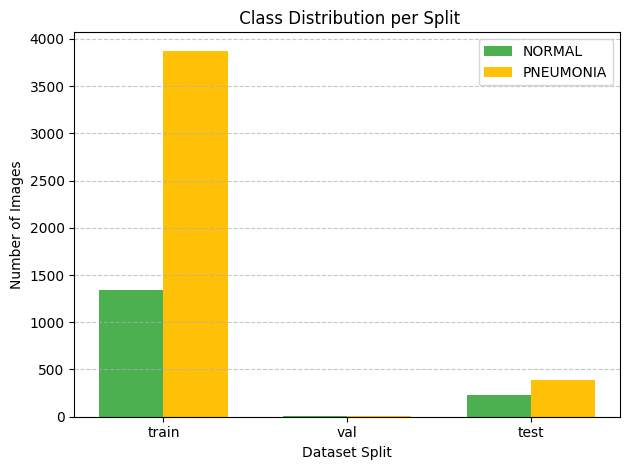

In [ ]:
def count_images_in_dir(base_dir):
    categories = ['NORMAL', 'PNEUMONIA']
    data_count = {}
    for category in categories:
        data_count[category] = {
            'train': len(os.listdir(os.path.join(base_dir, 'train', category))),
            'val': len(os.listdir(os.path.join(base_dir, 'val', category))),
            'test': len(os.listdir(os.path.join(base_dir, 'test', category)))
        }
    return data_count

# 📍 Base dataset directory
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# 📈 Count images
data_count = count_images_in_dir(base_dir)

# 🔁 Plotting
labels = list(data_count.keys())
splits = ['train', 'val', 'test']
colors = ['#4CAF50', '#FFC107', '#2196F3']

x = range(len(splits))
bar_width = 0.35

for idx, label in enumerate(labels):
    counts = [data_count[label][split] for split in splits]
    plt.bar([i + idx * bar_width for i in x], counts, width=bar_width, label=label, color=colors[idx])

plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.title(" Class Distribution per Split")
plt.xticks([r + bar_width / 2 for r in x], splits)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5.4: Rebuild Val Set from Training Data
Since we have 5,216 training images, we can extract a proper validation set from that using Stratified Split:

✅ We'll create new train_gen and val_gen from original train_dir only.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil
import os

# 🔍 1. Get all image paths and labels from original train_dir
def get_image_paths_labels(base_dir):
    categories = ['NORMAL', 'PNEUMONIA']
    data = []

    for label in categories:
        path = os.path.join(base_dir, label)
        for fname in os.listdir(path):
            data.append({
                'path': os.path.join(path, fname),
                'label': label
            })

    return pd.DataFrame(data)

df = get_image_paths_labels("/kaggle/input/chest-xray-pneumonia/chest_xray/train")

# 🎯 2. Stratified split: 85% train, 15% val
train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}")


Train: 4433, Val: 783


In [ ]:
print("Train:", train_df['label'].value_counts())
print("Val:", val_df['label'].value_counts())



Train: label
PNEUMONIA    3293
NORMAL       1140
Name: count, dtype: int64
Val: label
PNEUMONIA    582
NORMAL       201
Name: count, dtype: int64


In [ ]:
import shutil
import os

# 🗂️ Define base output folders
base_output = "chest_xray_split"
os.makedirs(base_output, exist_ok=True)

def copy_images(df, split_name):
    for label in ['NORMAL', 'PNEUMONIA']:
        split_folder = os.path.join(base_output, split_name, label)
        os.makedirs(split_folder, exist_ok=True)

    for _, row in df.iterrows():
        label = row['label']
        src = row['path']
        dst = os.path.join(base_output, split_name, label, os.path.basename(src))
        shutil.copy2(src, dst)

# 🚀 Copy images to new structure
copy_images(train_df, 'train')
copy_images(val_df, 'val')

print("✅ Images copied to chest_xray_split/train & val")


✅ Images copied to chest_xray_split/train & val


In [ ]:
base_output = "chest_xray_split"

train_datagen_new = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1, horizontal_flip=True)
val_datagen_new = ImageDataGenerator(rescale=1./255)


train_data = train_datagen_new.flow_from_directory(
    os.path.join(base_output, 'train'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_data = val_datagen_new.flow_from_directory(
    os.path.join(base_output, 'val'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 4433 images belonging to 2 classes.
Found 783 images belonging to 2 classes.


In [ ]:
print(os.listdir(train_dir))


['PNEUMONIA', 'NORMAL']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(base_output, 'train'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    os.path.join(base_output, 'val'),
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 4433 images belonging to 2 classes.
Found 783 images belonging to 2 classes.


# Step 6: Model Building using MobileNetV2 (Frozen Base + Custom Classifier)

We'll use **MobileNetV2**, a lightweight CNN architecture pretrained on ImageNet, and add a custom classification head for Pneumonia detection.

Advantages:
- Leverages strong pretrained features.
- Works well on medical images.
- Faster training and better generalization on smaller datasets.


## 6.1 Load MobileNetV2 (Frozen Base)
We load the MobileNetV2 model **without the top layers** and freeze its weights to use it as a **feature extractor**.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# 🎯 Input shape
input_shape = (224, 224, 3)

# 🔒 Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# ❄️ Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


/tmp/ipython-input-45-1028481357.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


##  6.2 Custom Head for Binary Classification

We add:
- `GlobalAveragePooling`: Reduce spatial dims.
- `Dropout`: Prevent overfitting.
- `Dense`: Learn task-specific features.
- `Sigmoid`: Output probability for binary classification.


In [ ]:
# 🧠 Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# 📦 Create final model
model = Model(inputs=base_model.input, outputs=output)


###  6.3 Compile the Model

We use:
- `Adam` optimizer with small learning rate
- `Binary Crossentropy` for 2-class problem
- `Accuracy` as the main metric


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Summary of the Model

In [ ]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 🧠 Step 6: Transfer Learning with MobileNetV2

We employ MobileNetV2 as a feature extractor to leverage pre-trained ImageNet knowledge and reduce overfitting risk on medical images.

**Architecture Overview:**
- ✅ Base: MobileNetV2 (frozen, no top layers)
- ✅ Head:
  - GlobalAveragePooling2D
  - Dense(128, ReLU)
  - Dropout (30%)
  - Output Layer: Dense(1, Sigmoid)

**Why This Architecture?**
- Efficient on small datasets
- Faster convergence
- Excellent performance on low-resource environments

**Loss**: Binary Crossentropy  
**Optimizer**: Adam (LR=1e-4)  


# Step 7: Model Training with Data Augmentation, Callbacks & Monitoring

In this step, we’ll:
- Enhance training using image augmentation.
- Prevent overfitting and track performance with callbacks.
- Train the model efficiently on GPU with live logs.

✅ Augmentation simulates real-world variations.
✅ Callbacks improve generalization and save best model.


### 🔹 7.1 Data Augmentation

We apply random transformations to make the model more robust to unseen test images and reduce overfitting.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_aug = ImageDataGenerator(rescale=1./255)


##  7.2 Setup Generators

In [ ]:
train_dir = 'chest_xray_split/train'
val_dir = 'chest_xray_split/val'

train_gen = train_aug.flow_from_directory(
    train_dir, target_size=(224, 224),
    batch_size=32, class_mode='binary', shuffle=True
)

val_gen = val_aug.flow_from_directory(
    val_dir, target_size=(224, 224),
    batch_size=32, class_mode='binary', shuffle=False
)


Found 4433 images belonging to 2 classes.
Found 783 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

##  7.3 Callbacks Used:
- **ModelCheckpoint**: Saves best weights only.
- **EarlyStopping**: Prevents overfitting by stopping early.
- **ReduceLROnPlateau**: Reduces LR if validation loss stagnates.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    "best_final_model.h5", monitor="val_auc",
    save_best_only=True, mode="max", verbose=1
)

early_cb = EarlyStopping(
    monitor="val_auc", patience=5,
    mode="max", restore_best_weights=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3,
    verbose=1, min_lr=1e-6
)

callbacks = [checkpoint_cb, early_cb, reduce_lr_cb]


## 7.4 Train the Model

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9500 - auc: 0.9875 - loss: 0.1261
Epoch 1: val_auc improved from -inf to 0.99167, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 88s 630ms/step - accuracy: 0.9500 - auc: 0.9875 - loss: 0.1262 - val_accuracy: 0.9361 - val_auc: 0.9917 - val_loss: 0.1371 - learning_rate: 1.0000e-04
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9476 - auc: 0.9873 - loss: 0.1285
Epoch 2: val_auc improved from 0.99167 to 0.99247, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 87s 623ms/step - accuracy: 0.9476 - auc: 0.9873 - loss: 0.1285 - val_accuracy: 0.9413 - val_auc: 0.9925 - val_loss: 0.1293 - learning_rate: 1.0000e-04
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9470 - auc: 0.9872 - loss: 0.1287
Epoch 3: val_auc improved from 0.99247 to 0.99257, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 622ms/step - accuracy: 0.9470 - auc: 0.9872 - loss: 0.1286 - val_accuracy: 0.9476 - val_auc: 0.9926 - val_loss: 0.1180 - learning_rate: 1.0000e-04
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9563 - auc: 0.9887 - loss: 0.1170
Epoch 4: val_auc did not improve from 0.99257
139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 620ms/step - accuracy: 0.9563 - auc: 0.9887 - loss: 0.1170 - val_accuracy: 0.9298 - val_auc: 0.9923 - val_loss: 0.1501 - learning_rate: 1.0000e-04
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9531 - auc: 0.9866 - loss: 0.1228
Epoch 5: val_auc improved from 0.99257 to 0.99267, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 87s 626ms/step - accuracy: 0.9530 - auc: 0.9866 - loss: 0.1228 - val_accuracy: 0.9451 - val_auc: 0.9927 - val_loss: 0.1172 - learning_rate: 1.0000e-04
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9496 - auc: 0.9894 - loss: 0.1160
Epoch 6: val_auc improved from 0.99267 to 0.99273, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 88s 635ms/step - accuracy: 0.9496 - auc: 0.9894 - loss: 0.1160 - val_accuracy: 0.9361 - val_auc: 0.9927 - val_loss: 0.1279 - learning_rate: 1.0000e-04
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9565 - auc: 0.9875 - loss: 0.1177
Epoch 7: val_auc improved from 0.99273 to 0.99325, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 620ms/step - accuracy: 0.9564 - auc: 0.9874 - loss: 0.1178 - val_accuracy: 0.9349 - val_auc: 0.9932 - val_loss: 0.1327 - learning_rate: 1.0000e-04
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9557 - auc: 0.9904 - loss: 0.1110
Epoch 8: val_auc improved from 0.99325 to 0.99346, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 87s 626ms/step - accuracy: 0.9557 - auc: 0.9904 - loss: 0.1111 - val_accuracy: 0.9579 - val_auc: 0.9935 - val_loss: 0.1037 - learning_rate: 1.0000e-04
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9464 - auc: 0.9872 - loss: 0.1271
Epoch 9: val_auc did not improve from 0.99346
139/139 ━━━━━━━━━━━━━━━━━━━━ 92s 661ms/step - accuracy: 0.9464 - auc: 0.9872 - loss: 0.1270 - val_accuracy: 0.9591 - val_auc: 0.9933 - val_loss: 0.1050 - learning_rate: 1.0000e-04
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9607 - auc: 0.9910 - loss: 0.1061
Epoch 10: val_auc improved from 0.99346 to 0.99362, saving model to best_final_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 88s 633ms/step - accuracy: 0.9607 - auc: 0.9910 - loss: 0.1061 - val_accuracy: 0.9553 - val_auc: 0.9936 - val_loss: 0.1077 - learning_rate: 1.0000e-04


## 🔍 Training Progress

We’ll visualize how well the model learns across epochs.


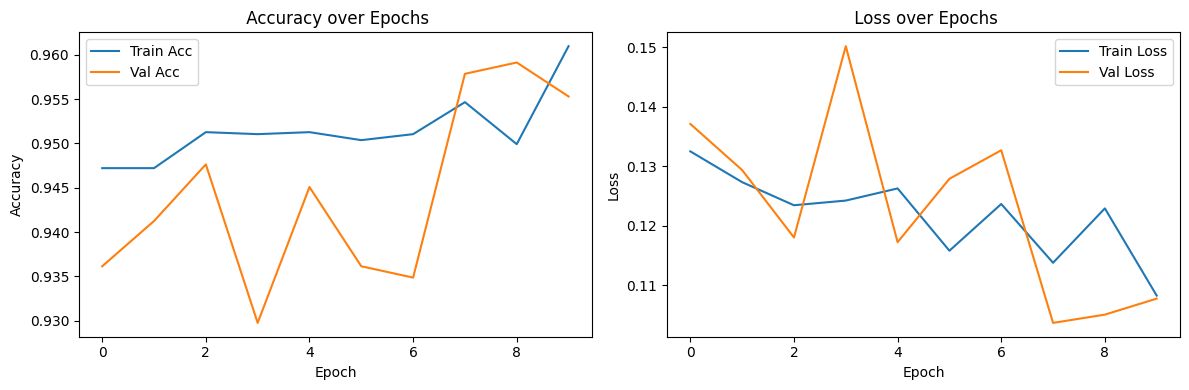

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(' Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(' Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

#  Step 8: Model Evaluation

We'll evaluate the trained model using:
- Classification report (Precision, Recall, F1)
- Confusion matrix (TP, TN, FP, FN)
- ROC-AUC curve (performance trade-off)


## 8.1 Load Test Set

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC

model = load_model("best_final_model.h5", compile=False)

# Compile again with metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_aug = ImageDataGenerator(rescale=1./255)

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

test_gen = test_aug.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 624 images belonging to 2 classes.


##  8.2 Load Best Model and Predict

In [ ]:
import numpy as np

# Predict probabilities and convert to binary
pred_probs = model.predict(test_gen, verbose=1)
preds = (pred_probs > 0.5).astype("int32").flatten()

true_labels = test_gen.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Accuracy
acc = accuracy_score(true_labels, preds)

# AUC
auc_score = roc_auc_score(true_labels, pred_probs)

# Classification Report
report = classification_report(true_labels, preds, target_names=['NORMAL', 'PNEUMONIA'])

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)

print("✅ Test Accuracy:", acc)
print("✅ Test AUC:", auc_score)
print("\n📄 Classification Report:\n", report)
print("🔀 Confusion Matrix:\n", cm)


✅ Test Accuracy: 0.8717948717948718
✅ Test AUC: 0.967674775367083

📄 Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.96      0.69      0.80       234
   PNEUMONIA       0.84      0.98      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.84      0.85       624
weighted avg       0.88      0.87      0.87       624

🔀 Confusion Matrix:
 [[161  73]
 [  7 383]]


## 8.3 Classification Report

## 8.4 Confusion Matrix

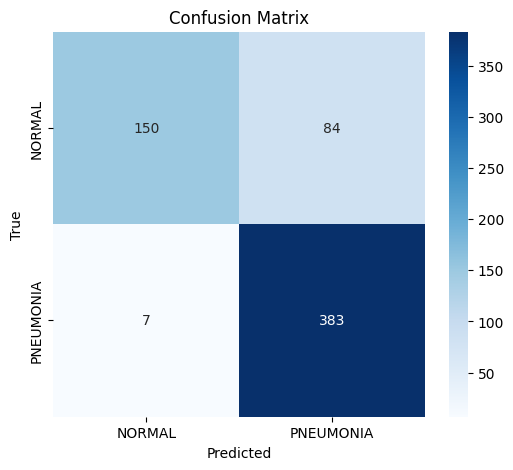

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Accuracy_score


In [106]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(true_labels, preds)
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.8718


## 8.5 ROC Curve & AUC

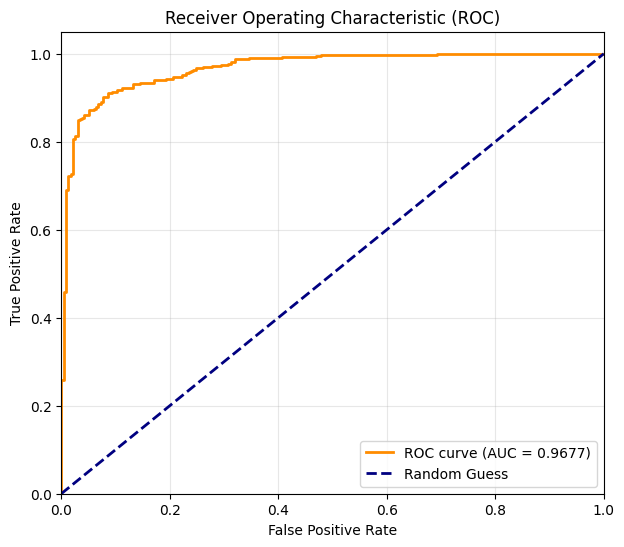

In [108]:
from sklearn.metrics import roc_curve, auc

# Get False Positive Rate, True Positive Rate
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


- High Recall = better pneumonia detection (catching most cases)
- Confusion Matrix reveals misclassified X-rays
- AUC closer to 1 = better discrimination between Normal and Pneumonia


## 🔍 Step 9: Explainability with Grad-CAM

We will apply Grad-CAM to:
- Visualize which X-ray regions influenced the model's "Pneumonia" prediction.
- Help radiologists & practitioners trust the model.


In [109]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os

def load_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array / 255.0  # Normalize


##  9.2 Grad-CAM Utility Function

In [110]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


##  9.3 Overlay Heatmap on Original X-ray

In [111]:
def display_gradcam(img, heatmap, alpha=0.4):
    img = np.array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * alpha + img
    plt.figure(figsize=(8, 6))
    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()


##  9.4 Run Grad-CAM on a Sample X-ray

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: NORMAL (81.52%)


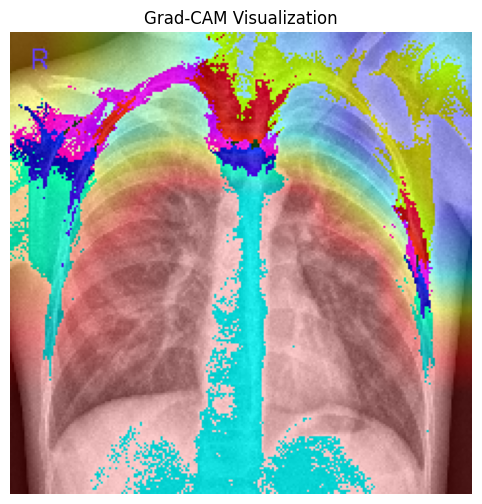

In [115]:
# 🔍 Input your image path here
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0037-0001.jpeg"

# 1. Load image
img, img_array = load_image(image_path)

# 2. Predict
pred = model.predict(img_array)[0][0]
label = "PNEUMONIA" if pred > 0.5 else "NORMAL"
confidence = pred if pred > 0.5 else 1 - pred
print(f"Prediction: {label} ({confidence*100:.2f}%)")

# 3. Grad-CAM
last_conv_layer = "Conv_1"  # Last conv layer in MobileNetV2
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

# 4. Display
display_gradcam(img, heatmap)


✅ Interpretation:
- The highlighted red/yellow regions show where the model detected pneumonia.
- Useful for radiologists and model verification.
